> **IMPORTANT**: Before running this notebook, ensure you have ran:
> ```bash
> python ./scripts/preprocessing/preprocess_data.py
> ``` 
> You will know if you ran this if you see a `pickled_objects` folder in your root directory. This folder will be used to load in preprocessed data and the saved preprcoessor.

# Import Libraries

In [1]:
from utils.preprocessing import load_preprocessed_data, load_preprocessor
from models.mlp import MLP, Trainer, ASLDataset, plot_history
from models.sklearn import SklearnClassifier, load_model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from typing import Literal
from collections import defaultdict
import pickle
from xgboost import XGBClassifier

I0000 00:00:1733106875.529494 5237054 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1733106875.534677 5237295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733106875.538630 5237298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [2]:
# Define dictionary for scores
models = defaultdict(dict[Literal['val_accuracy', 'test_accuracy'], float]) 

# Get Data and Preprocesssor

In [3]:
train_data = load_preprocessed_data('train')
val_data = load_preprocessed_data('val')
test_data = load_preprocessed_data('test')
preprocessor = load_preprocessor()

In [4]:
train_data[0].shape

(14277, 4096)

# Train Models

## KNN

### Train and Evaluate Model

In [5]:
knn = SklearnClassifier(
    classifier=KNeighborsClassifier(n_neighbors=4),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
knn.fit(model_name='knn')

# Get cross val score
val_score_knn = knn.val_acc_score()
models['KNN']['val_accuracy'] = val_score_knn
print(f'KNN Validation Score: {val_score_knn:.4f}')

# Get test score
test_score_knn = knn.test_acc_score()
models['KNN']['test_accuracy'] = test_score_knn
print(f'KNN Test Score: {test_score_knn:.4f}')

Saved knn to pickled_objects/knn.pkl
KNN Validation Score: 0.3275
KNN Test Score: 0.3345


### Load in Pickled Model

In [6]:
knn = load_model('knn')
knn

KNeighborsClassifier(n_neighbors=4)

### Get Classification Report

In [7]:
y_true = test_data[-1]
y_pred = knn.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       1.00      0.56      0.72        55
           B       1.00      0.56      0.72        80
       Blank       0.07      1.00      0.13       100
           C       1.00      0.51      0.68        78
           D       1.00      0.04      0.08        73
           E       0.96      0.40      0.56        68
           F       1.00      0.06      0.11        85
           G       1.00      0.03      0.07        88
           H       1.00      0.34      0.51        85
           I       1.00      0.65      0.79        78
           J       1.00      0.06      0.11        69
           K       1.00      0.27      0.42        90
           L       1.00      0.26      0.42        87
           M       1.00      0.28      0.44        57
           N       0.98      0.48      0.65        89
           O       1.00      0.29      0.45        66
           P       0.00      0.00      0.00        60
           Q       0.00    

/Users/danielplotkin/Documents/MSAI/courses/fall_2024/machine_learning/homework/msai349/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielplotkin/Documents/MSAI/courses/fall_2024/machine_learning/homework/msai349/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/danielplotkin/Documents/MSAI/courses/fall_2024/machine_learning/homework/msai349/project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetric

## Random Forest

### Fit and Evaluation Model

In [8]:
rf = SklearnClassifier(
    classifier=RandomForestClassifier(n_estimators=50),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
rf.fit(model_name='random_forest')

# Get cross val score
val_score_rf = rf.val_acc_score()
models['Random Forest']['val_accuracy'] = val_score_rf
print(f'Random Forest Validation Score: {val_score_rf:.4f}')

# Get test score
test_score_rf = rf.test_acc_score()
models['Random Forest']['test_accuracy'] = test_score_rf
print(f'Random Forest Test Score: {test_score_rf:.4f}')

Saved random_forest to pickled_objects/random_forest.pkl
Random Forest Validation Score: 0.8583
Random Forest Test Score: 0.8481


### Load in Pickled Model

In [9]:
rf = load_model('random_forest')
rf

RandomForestClassifier(n_estimators=50)

### Get Classification Report

In [10]:
y_true = test_data[-1]
y_pred = rf.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.80      0.89      0.84        55
           B       0.89      0.88      0.88        80
       Blank       0.95      1.00      0.98       100
           C       0.77      0.92      0.84        78
           D       0.82      0.85      0.83        73
           E       0.83      0.91      0.87        68
           F       0.76      0.92      0.83        85
           G       0.69      0.86      0.77        88
           H       0.85      0.98      0.91        85
           I       0.91      0.92      0.92        78
           J       0.67      0.61      0.64        69
           K       0.92      0.90      0.91        90
           L       0.79      0.97      0.87        87
           M       0.97      0.60      0.74        57
           N       0.84      0.91      0.87        89
           O       0.90      0.95      0.93        66
           P       0.84      0.27      0.41        60
           Q       0.53    

## XGBoost

## Fit and Evaluate Model

In [11]:
xgb = SklearnClassifier(
    classifier=XGBClassifier(),
    train_data=train_data,
    test_data=test_data,
    val_data=val_data
)

# Fit model
xgb.fit(model_name='xgboost')

# Get cross val score
val_score_xgb = xgb.val_acc_score()
models['XGBoost']['val_accuracy'] = val_score_xgb
print(f'XGBoost Validation Score: {val_score_xgb:.4f}')

# Get test score
test_score_xgb = xgb.test_acc_score()
models['XGBoost']['test_accuracy'] = test_score_xgb
print(f'XGBoost Test Score: {test_score_xgb:.4f}')

Saved xgboost to pickled_objects/xgboost.pkl
XGBoost Validation Score: 0.9055
XGBoost Test Score: 0.9002


### Load in Pickled Model

In [12]:
xgb = load_model('xgboost')
xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Get Classification Report

In [13]:
y_true = test_data[-1]
y_pred = xgb.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.92      0.84      0.88        55
           B       0.92      0.91      0.92        80
       Blank       0.93      1.00      0.97       100
           C       0.96      0.92      0.94        78
           D       0.89      0.86      0.88        73
           E       0.91      0.90      0.90        68
           F       0.86      0.93      0.89        85
           G       0.89      0.93      0.91        88
           H       0.98      1.00      0.99        85
           I       0.97      0.90      0.93        78
           J       0.68      0.72      0.70        69
           K       0.92      0.90      0.91        90
           L       0.93      0.98      0.96        87
           M       0.80      0.61      0.69        57
           N       0.90      0.90      0.90        89
           O       0.91      0.95      0.93        66
           P       0.85      0.75      0.80        60
           Q       0.88    

## MLP

### Initialize Network

In [14]:
input_dim = train_data[0].shape[-1]
output_dim = len(np.unique(train_data[-1]))
model = MLP(input_dim=input_dim, output_dim=output_dim)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=128, out_features=27, bias=True)
  )
)


### Initialize Trainer

In [15]:
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    learning_rate=5e-4,
    loss_fn=nn.CrossEntropyLoss(),
    dataset_cls=ASLDataset,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    batch_size=32,
    num_epochs=100,
    optimizer_kwargs={'weight_decay': 1e-4}, # Add l2 regularization
    patience=5
)

### Train Model

In [16]:
history = trainer.train()

Epoch 1/100:


Val Loss: 0.3719, Val Acc: 0.8961: 100%|██████████| 114/114 [00:00<00:00, 238.07it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 2/100:


Val Loss: 0.3034, Val Acc: 0.9179: 100%|██████████| 114/114 [00:00<00:00, 256.52it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 3/100:


Val Loss: 0.3606, Val Acc: 0.9107: 100%|██████████| 114/114 [00:00<00:00, 249.53it/s]



Epoch 4/100:


Val Loss: 0.3532, Val Acc: 0.9159: 100%|██████████| 114/114 [00:00<00:00, 242.96it/s]



Epoch 5/100:


Val Loss: 0.3482, Val Acc: 0.9184: 100%|██████████| 114/114 [00:00<00:00, 240.83it/s]



Epoch 6/100:


Val Loss: 0.3739, Val Acc: 0.9118: 100%|██████████| 114/114 [00:00<00:00, 249.83it/s]



Epoch 7/100:


Val Loss: 0.3982, Val Acc: 0.9140: 100%|██████████| 114/114 [00:00<00:00, 242.70it/s]


Early stopping triggered at epoch 7.
Restoring weights back to epoch 2.


### Visualize Training

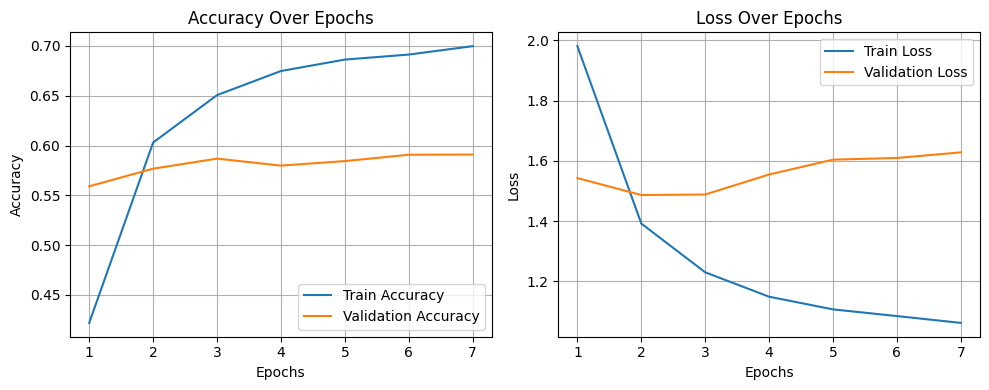

In [17]:
plot_history(history=history)

### Load in Cached Weights (only if they are not in memory)

In [17]:
trainer.load_checkpointed_weights('weights/best_model_checkpoint.pth')
trainer.batch_loaders()

Successfully loaded in weights from weights/best_model_checkpoint.pth.


### Pickle Trainer

In [18]:
with open('pickled_objects/trainer.pkl', 'wb') as f:
    pickle.dump(trainer, f)

### Evalaute Model on Val and Test Set 

In [19]:
val_stats = trainer.evaluate(loader_type='val')
models['MLP']['val_accuracy'] = val_stats['accuracy']

Val Loss: 0.3034, Val Acc: 0.9179: 100%|██████████| 114/114 [00:00<00:00, 234.54it/s]


In [20]:
test_stats = trainer.evaluate(loader_type='test')
models['MLP']['test_accuracy'] = test_stats['accuracy']

Test Loss: 0.2905, Test Acc: 0.9151: 100%|██████████| 63/63 [00:00<00:00, 232.82it/s]


### Get Full Classification Report

In [21]:
preds = preprocessor.label_encoder.inverse_transform(torch.cat([trainer.predict(x.reshape(1, -1)) for x in test_data[0]]).numpy())
truths = preprocessor.label_encoder.inverse_transform(test_data[-1])

In [22]:
report = classification_report(y_true=truths, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           A       0.96      0.95      0.95        55
           B       0.97      0.93      0.95        80
       Blank       1.00      1.00      1.00       100
           C       0.93      0.99      0.96        78
           D       0.88      0.95      0.91        73
           E       0.88      0.94      0.91        68
           F       0.91      0.98      0.94        85
           G       0.90      0.89      0.89        88
           H       1.00      1.00      1.00        85
           I       0.94      0.96      0.95        78
           J       0.75      0.86      0.80        69
           K       0.99      0.86      0.92        90
           L       0.98      0.95      0.97        87
           M       0.86      0.65      0.74        57
           N       0.91      0.92      0.92        89
           O       0.95      0.92      0.94        66
           P       1.00      0.58      0.74        60
           Q       0.64    

# Compare Models

In [23]:
# Convert models DataFrame to a styled DataFrame and remove trailing zeros
models_df = pd.DataFrame(models)  # Convert to DataFrame
models_df = models_df.map(lambda x: ('%.4f' % x)).T  # Remove trailing zeros
models_df.sort_values('test_accuracy', ascending=False, inplace=True)  # Sort by test accuracy

# Highlight best model
top_model = models_df.index[0]
df_styled = models_df.style.apply(
    lambda row: ['background-color: green' if row.name == top_model else '' for _ in row], axis=1
)
df_styled

,val_accuracy,test_accuracy
MLP,0.9179,0.9151
XGBoost,0.9055,0.9002
Random Forest,0.8583,0.8481
KNN,0.3275,0.3345
